***EDA***\
\
Code for Participants' demographics:

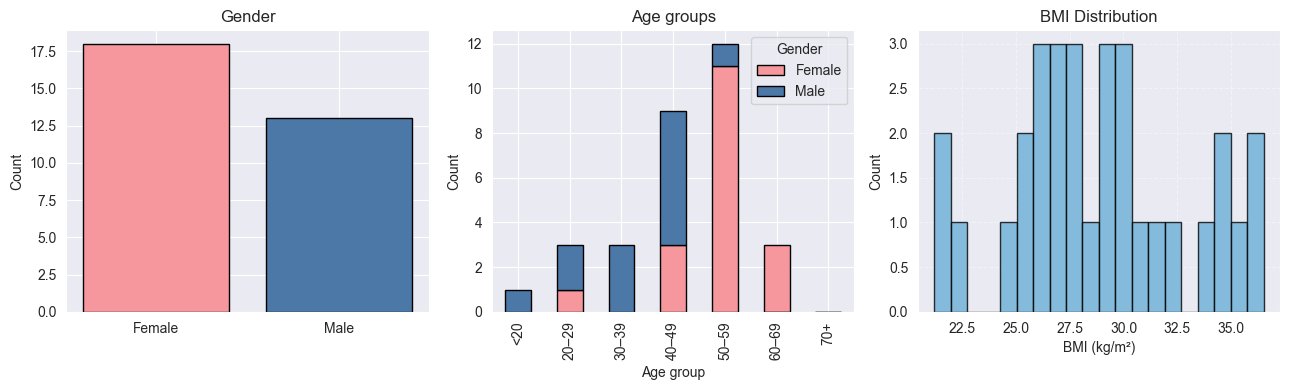

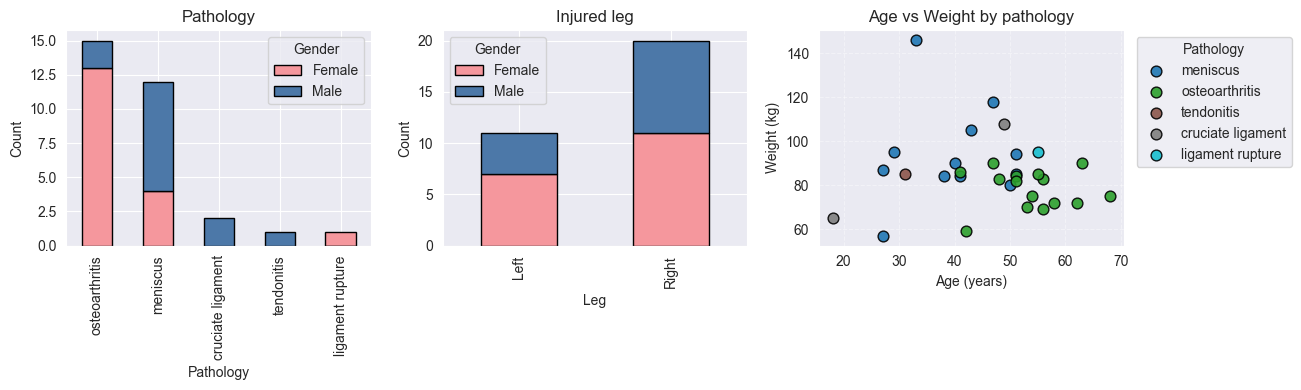

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import io
from pathlib import Path

# Path to save the figures
SAVE_DIR = Path(r"C:\Users\20230931\PycharmProjects\Recommender-Systems-for-Time-Series-Data-in-Knee-Osteoarthritis-Management\figures")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Extract metadata.txt
def extract_table(text: str, header_prefix: str):
    lines = text.splitlines()
    try:
        start = next(i for i, ln in enumerate(lines) if ln.strip().startswith(header_prefix))
    except StopIteration:
        raise ValueError(f"Header '{header_prefix}' not found in metadata.")

    end = len(lines)
    for j in range(start + 1, len(lines)):
        if lines[j].strip().startswith("Table "):
            end = j
            break
    block = "\n".join(lines[start:end])
    return pd.read_csv(io.StringIO(block), sep="\t")

# load raw text
with open("metadata.txt", "r", encoding="utf-8") as f:
    text = f.read()

participants_df = extract_table(text, "Participant ID")
sensor_cfg_df   = extract_table(text, "Number of Sensors")
placements_df   = extract_table(text, "Sensor ID")
labels_df       = extract_table(text, "Label ID")

# Clean participant data
participants_df = participants_df.rename(columns={
    "Participant ID": "participant_id",
    "Gender (M/F)": "gender",
    "Height (CM)": "height_raw",
    "Weight(KG)": "weight_kg",
    "Age (Years)": "age_years",
    "Leg": "leg",
    "Pathology": "pathology"
})

# strip/normalize
participants_df["gender"] = participants_df["gender"].str.strip().str.title()
participants_df["leg"]    = participants_df["leg"].str.strip().str.title()
participants_df["pathology"] = participants_df["pathology"].str.strip().str.lower()

# numeric conversions
participants_df["age_years"] = pd.to_numeric(participants_df["age_years"], errors="coerce")
participants_df["weight_kg"] = pd.to_numeric(participants_df["weight_kg"], errors="coerce")
participants_df["height_raw"] = pd.to_numeric(participants_df["height_raw"], errors="coerce")

# nomralize height column 
if participants_df["height_raw"].max() < 3.5:
    participants_df["height_m"]  = participants_df["height_raw"]
    participants_df["height_cm"] = participants_df["height_raw"] * 100
else:
    participants_df["height_cm"] = participants_df["height_raw"]
    participants_df["height_m"]  = participants_df["height_raw"] / 100.0

# age groups (bins)
age_labels = ["<20", "20–29", "30–39", "40–49", "50–59", "60–69", "70+"]
participants_df["age_group"] = pd.cut(
    participants_df["age_years"],
    bins=[0, 20, 30, 40, 50, 60, 70, 200],
    labels=age_labels,
    right=False
)

# order categories
participants_df["gender"] = pd.Categorical(participants_df["gender"], categories=["Female", "Male"], ordered=True)
participants_df["leg"] = pd.Categorical(participants_df["leg"], categories=["Left", "Right"], ordered=True)


mpl.rcParams.update({"font.size": 10})
GENDER_COLORS = {"Female": "#F5979D", "Male": "#4C78A8"}

# Demographics plots - figA
figA, axesA = plt.subplots(1, 3, figsize=(13, 4))
ax1, ax2, ax3 = axesA

# Gender plot
gender_counts = participants_df["gender"].value_counts().reindex(["Female", "Male"]).fillna(0)
ax1.bar(gender_counts.index, gender_counts.values,
        color=[GENDER_COLORS[g] for g in gender_counts.index], edgecolor="black")
ax1.set_title("Gender")
ax1.set_ylabel("Count")

# Age groups plot
age_gender_ct = pd.crosstab(participants_df["age_group"], participants_df["gender"]).reindex(age_labels).fillna(0)
age_gender_ct.plot(kind="bar", stacked=True,
                   color=[GENDER_COLORS.get(col, "gray") for col in age_gender_ct.columns],
                   edgecolor="black", ax=ax2)
ax2.set_title("Age groups")
ax2.set_xlabel("Age group")
ax2.set_ylabel("Count")
ax2.legend(title="Gender")

# BMI histogram (overall)
participants_df["BMI"] = participants_df["weight_kg"] / (participants_df["height_m"] ** 2)

ax3.hist(participants_df["BMI"].dropna(), bins=20,
         color="#6BAED6", edgecolor="black", alpha=0.8)
ax3.set_title("BMI Distribution")
ax3.set_xlabel("BMI (kg/m²)")
ax3.set_ylabel("Count")
ax3.grid(True, linestyle="--", alpha=0.4)

figA.tight_layout()
# figA.savefig(SAVE_DIR / "participants_demographics.png", dpi=300, bbox_inches="tight")
plt.show()


# Clinical characteristics plots - figB
figB, axesB = plt.subplots(1, 3, figsize=(13, 4))
bx1, bx2, bx3 = axesB

# Pathology plot
pth_order = participants_df["pathology"].value_counts().index.tolist()
pth_gender_ct = pd.crosstab(participants_df["pathology"], participants_df["gender"]).reindex(pth_order).fillna(0)
pth_gender_ct.plot(kind="bar", stacked=True,
                   color=[GENDER_COLORS.get(col, "gray") for col in pth_gender_ct.columns],
                   edgecolor="black", ax=bx1)
bx1.set_title("Pathology")
bx1.set_xlabel("Pathology")
bx1.set_ylabel("Count")
bx1.legend(title="Gender")

# Injured leg plot
leg_gender_ct = pd.crosstab(participants_df["leg"], participants_df["gender"]).reindex(["Left", "Right"]).fillna(0)
leg_gender_ct.plot(kind="bar", stacked=True,
                   color=[GENDER_COLORS.get(col, "gray") for col in leg_gender_ct.columns],
                   edgecolor="black", ax=bx2)
bx2.set_title("Injured leg")
bx2.set_xlabel("Leg")
bx2.set_ylabel("Count")
bx2.legend(title="Gender")

# Age vs Weight plot
uniq_patho = [p for p in participants_df["pathology"].dropna().unique()]
cmap = plt.get_cmap("tab10", len(uniq_patho))
for i, pth in enumerate(uniq_patho):
    sub = participants_df[participants_df["pathology"] == pth]
    bx3.scatter(sub["age_years"], sub["weight_kg"], label=pth,
                color=cmap(i), alpha=0.9, edgecolor="black", s=60)
bx3.set_title("Age vs Weight by pathology")
bx3.set_xlabel("Age (years)")
bx3.set_ylabel("Weight (kg)")
bx3.grid(True, linestyle="--", alpha=0.4)
bx3.legend(title="Pathology", bbox_to_anchor=(1.02, 1), loc="upper left")

figB.tight_layout()
# figB.savefig(SAVE_DIR / "participants_clinical.png", dpi=300, bbox_inches="tight")

plt.show()


Code for trials distribution

Number of Trials per Class
Class 0: 840 trials
Class 1: 475 trials
Class 2: 432 trials
Class 3: 404 trials
Class 4: 318 trials
Class 5: 480 trials
Class 6: 485 trials
Class 7: 704 trials
Class 8: 695 trials
Total trials: 4833



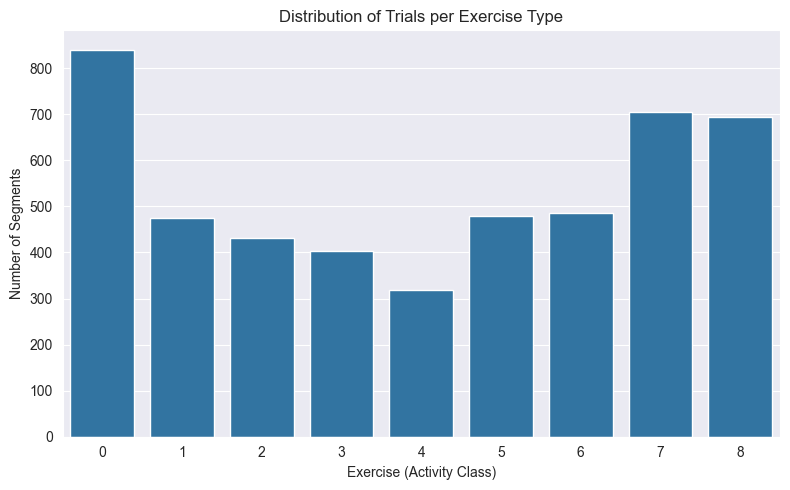

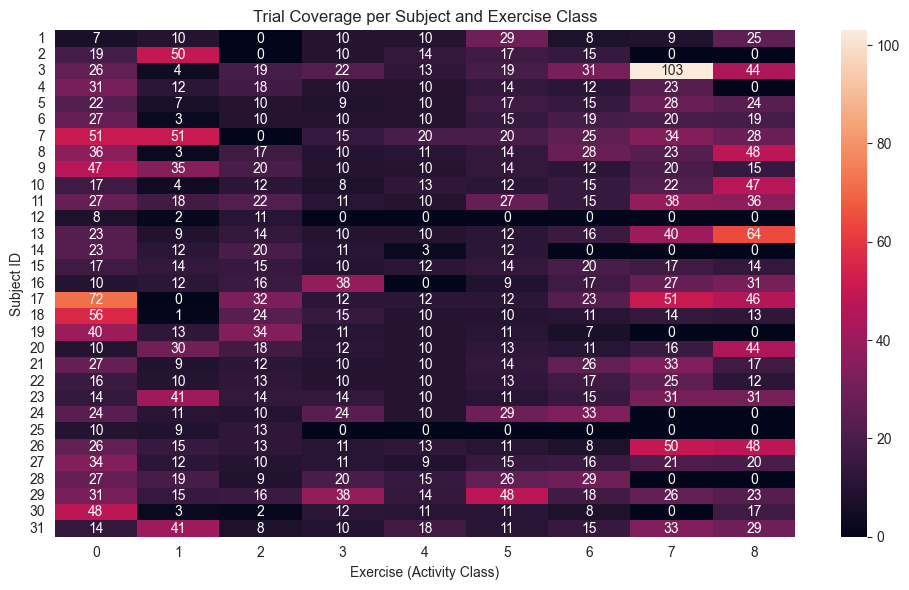

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# load data
emg = np.load("emg_all.npy", allow_pickle=True)
imu = np.load("imu_all.npy", allow_pickle=True)
labels = np.load("labels_all.npy", allow_pickle=True)
subjects = np.load("subjects_all.npy", allow_pickle=True)

# number of trials per class
unique_labels, counts = np.unique(labels, return_counts=True)

print("Number of Trials per Class")
for lbl, cnt in zip(unique_labels, counts):
    print(f"Class {lbl}: {cnt} trials")
print(f"Total trials: {len(labels)}\n")


plt.figure(figsize=(8,5))
sns.barplot(x=unique_labels, y=counts)
plt.xlabel("Exercise (Activity Class)")
plt.ylabel("Number of Segments")
plt.title("Distribution of Trials per Exercise Type")
plt.tight_layout()
# plt.savefig("figures/class_distribution_fixed.png", dpi=300)
plt.show()

# heatmap: trial coverage per subject and exercise
df = pd.DataFrame({'subject': subjects, 'label': labels})
pivot = pd.crosstab(df['subject'], df['label'])

plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, fmt="d")
plt.xlabel("Exercise (Activity Class)")
plt.ylabel("Subject ID")
plt.title("Trial Coverage per Subject and Exercise Class")
plt.tight_layout()
# plt.savefig("figures/subject_class_heatmap.png", dpi=300)
plt.show()


Example time series (sEMG vs IMU from same trial)

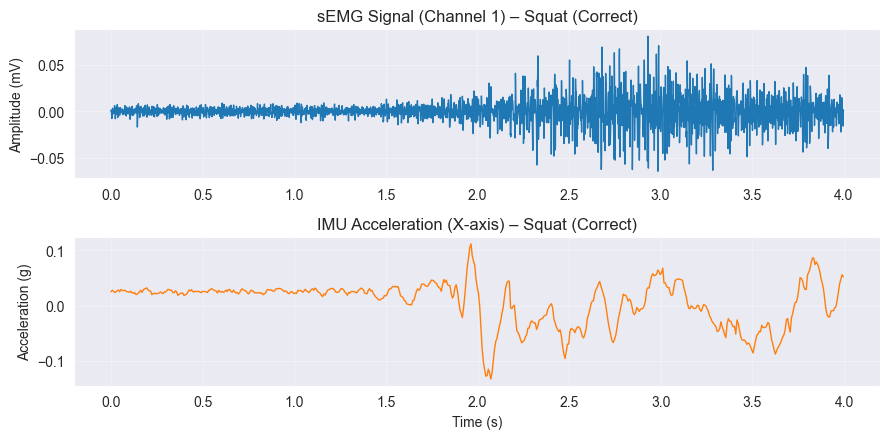

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os

# load data
emg = np.load("emg_all.npy", allow_pickle=True)
imu = np.load("imu_all.npy", allow_pickle=True)
labels = np.load("labels_all.npy", allow_pickle=True)

# Map class IDs to exercise names
class_names = {
    0: "Squat (Correct)",
    1: "Squat – Weight Transfer (Incorrect)",
    2: "Squat – Front Leg (Incorrect)",
    3: "Knee Extension (Correct)",
    4: "Extension – Not Full Range (Incorrect)",
    5: "Extension – Limb Lift (Incorrect)",
    6: "Gait (Normal)",
    7: "Gait – Not Full Extension (Incorrect)",
    8: "Gait – Hip Abduction (Incorrect)"
}

# example exercise
target_class = 0
indices = np.where(labels == target_class)[0]
i = indices[len(indices)//2 + 1] 

# sampling rates and time axes
fs_emg = 1259.26
fs_imu = 148.15
t_emg = np.arange(emg.shape[-1]) / fs_emg
t_imu = np.arange(imu.shape[-1]) / fs_imu

emg_ch = 0 
imu_axis = 0 

emg_sig = emg[i, emg_ch, :] 
imu_sig = imu[i, imu_axis, :]

# plot
plt.figure(figsize=(9, 4.5))

plt.subplot(2, 1, 1)
plt.plot(t_emg, emg_sig, color='tab:blue', lw=1)
plt.title(f"sEMG Signal (Channel {emg_ch + 1}) – {class_names[target_class]}")
plt.ylabel("Amplitude (mV)")
plt.grid(alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(t_imu, imu_sig, color='tab:orange', lw=1)
plt.title(f"IMU Acceleration (X-axis) – {class_names[target_class]}")
plt.ylabel("Acceleration (g)")
plt.xlabel("Time (s)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures/signal_example.png", dpi=300)
plt.show()
